# Toolbox *physio*
- Process respiratory signal --> Respiration Features cycle by cycle
- Process ECG signal --> Heart Rate Variability Features (time and frequency domain)
- Build instantaneous heart heart signal from ECG
- Compute Respiratory Heart rate Variability Features cycle by cycle

# Useful ressources

- Documentation : https://physio.readthedocs.io/en/latest/index.html
- Github : https://github.com/samuelgarcia/physio/tree/main
- Article (to cite if you used physio for a publication)  : https://www.eneuro.org/content/10/10/ENEURO.0197-23.2023

# Installation
- pip install physio

# Imports

In [2]:
import numpy as np # to manipulate ND arrays
import matplotlib.pyplot as plt # to plot things
import pandas as pd # to manipulate tables excel like

import physio # to process respi and ecg signals

# activate (uncomment) / deactivate (comment) this following line to generate non-zoomable plots directly built in the notebook
# %matplotlib inline 

# activate (uncomment) / deactivate (comment) this following line to generate zoomable plots  
%matplotlib widget 

# Read data using physio
*physio* provides utility functions for reading certain formats, such as *micromed* or *brainvision*

In [3]:
data_file = '../data/example.vhdr'

In [4]:
raw_resp, srate = physio.read_one_channel(data_file, format='brainvision', channel_name='RespiNasale') # load raw respiratory airflow nasal signal and its sample rate
print(raw_resp.shape, srate)

(3182940,) 1000.0


In [5]:
raw_ecg, srate = physio.read_one_channel(data_file, format='brainvision', channel_name='ECG') # load raw ECG signal and its sample rate
print(raw_resp.shape, srate)

(3182940,) 1000.0


In [6]:
raw_resp *= -1 # just reverse the signal because inspiration must point downward for human_airflow, because downward deflections are interpreted by physio as inspirations
raw_ecg *= -1 # just reverse the signal because R peaks must point upward for the highest probability of detection by physio. This may vary according to the subjects.

In [7]:
times = np.arange(raw_resp.size) / srate # compute time vector of the signals
print(times)
print('Recording duration in seconds :', times[-1])

[0.000000e+00 1.000000e-03 2.000000e-03 ... 3.182937e+03 3.182938e+03
 3.182939e+03]
Recording duration in seconds : 3182.939


## Define protocol periods
These periods corresponded to 2 or 3 trials of 3 or 5 minutes for 4 different respiratory blocks/conditions :
- free : Participant is asked to breath naturally (2 trials of 5 minutes)
- slow : Participant follows a visual cue with his own respiration to breath at 0.1 Hz (3 trials of 3 minutes)
- base : Participant follows a visual cue with his own respiration to breath at the same rate than during *free*, meaning its natural prominent frequency (3 trials of 3 minutes)
- fast : Participant follows a visual cue with his own respiration to breath at 0.4 Hz (3 trials of 3 minutes)

In [8]:
periods = pd.DataFrame({
    'block_type': ['free', 'free', 'fast', 'fast', 'fast', 'base', 'base', 'base', 'slow', 'slow', 'slow', ],
    'trial_num': [ 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3,],
    'start_time' : [56.938, 2869.336, 634.304, 1863.984, 2610.284, 883.562, 1372.779, 1611.302, 1132.622, 2122.235, 2368.016],
    'duration' : [300., 300., 180., 180., 180., 180., 180., 180., 180., 180., 180.,  ],
    
})
periods['stop_time'] = periods['start_time'] + periods['duration']
periods = periods.set_index(['block_type', 'trial_num'])
periods

start_time  duration  stop_time
block_type trial_num                                 
free       1              56.938     300.0    356.938
           2            2869.336     300.0   3169.336
fast       1             634.304     180.0    814.304
           2            1863.984     180.0   2043.984
           3            2610.284     180.0   2790.284
base       1             883.562     180.0   1063.562
           2            1372.779     180.0   1552.779
           3            1611.302     180.0   1791.302
slow       1            1132.622     180.0   1312.622
           2            2122.235     180.0   2302.235
           3            2368.016     180.0   2548.016

# Plotting Raw signals

Text(0, 0.5, 'AU')

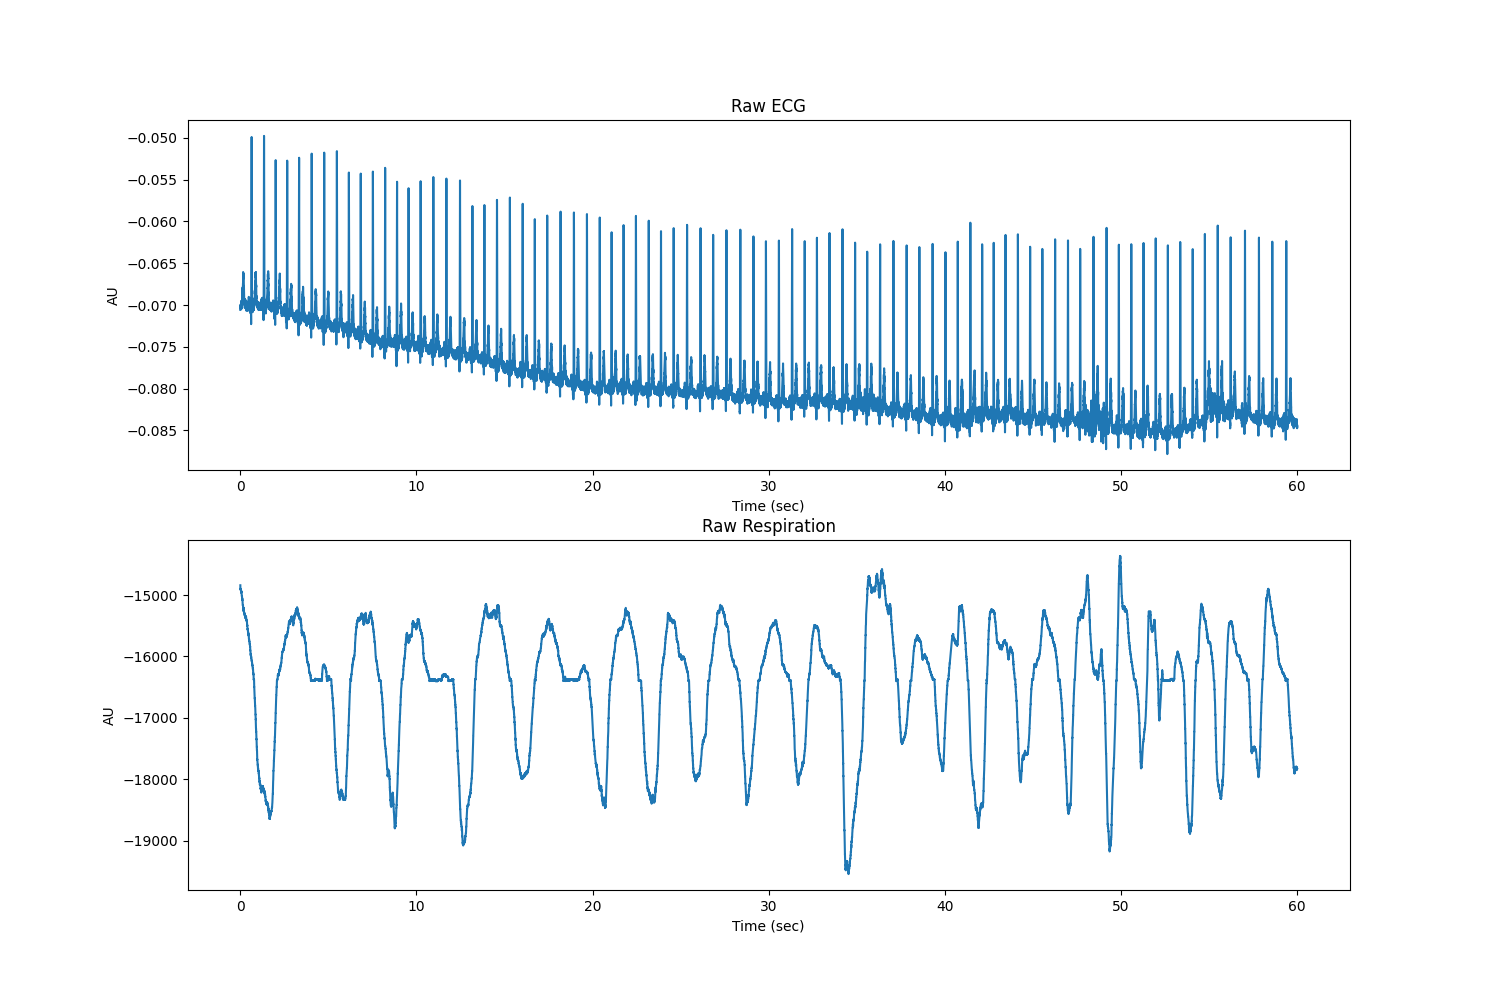

In [9]:
start, stop = 0, 60 # set some start and stop timings in seconds

mask_t = (times > start) & (times < stop)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

ax = axs[0]
ax.set_title('Raw ECG')
ax.plot(times[mask_t], raw_ecg[mask_t])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('AU')

ax = axs[1]
ax.set_title('Raw Respiration')
ax.plot(times[mask_t], raw_resp[mask_t])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('AU')

# Respiratory analysis
See : https://physio.readthedocs.io/en/latest/examples/example_02_respiration.html

## Setting parameters using *parameter_preset* = a tree of parameters already prepared by the developers

In [10]:
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_preset='human_airflow') # using parameter_preset human_airflow
print(resp.shape, resp_cycles.shape)

print('Number of detected respiratory cycles :', resp_cycles.shape[0])

(3182940,) (832, 21)
Number of detected respiratory cycles : 832


In [11]:
# just print a view of the parameters used
physio.get_respiration_parameters('human_airflow') # human_airflow, human_co2, human_belt, rat_plethysmo, rat_etisens_belt

{'sensor_type': 'airflow',
 'preprocess': {'band': 7.0,
  'btype': 'lowpass',
  'ftype': 'bessel',
  'order': 5},
 'smooth': {'win_shape': 'gaussian', 'sigma_ms': 60.0},
 'cycle_detection': {'method': 'crossing_baseline',
  'epsilon_factor1': 10.0,
  'epsilon_factor2': 5.0,
  'inspiration_adjust_on_derivative': False},
 'baseline': {'baseline_mode': 'median'},
 'cycle_clean': {'variable_names': ['inspi_volume', 'expi_volume'],
  'low_limit_log_ratio': 4.5}}

## Customising parameters if the default are not satisfying
See : https://physio.readthedocs.io/en/latest/handling_parameters.html#a-airflow

In [12]:
parameters = physio.get_respiration_parameters('human_airflow') # allocating parameters (a python dict) to a value
parameters['preprocess']['band'] = 2 # let's change for example the cutoff of the low-pass frequency by changing the key / subkey value
resp2, resp_cycles2 = physio.compute_respiration(raw_resp, srate, parameters = parameters) # and compute cycles with the new set of parameters
print(resp2.shape, resp_cycles2.shape)
print('Number of detected respiratory cycles :', resp_cycles2.shape[0])

(3182940,) (832, 21)
Number of detected respiratory cycles : 832


## See table of respiratory cycles

In [13]:
resp_cycles

,inspi_index,expi_index,next_inspi_index,inspi_time,expi_time,next_inspi_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,...,inspi_volume,expi_volume,total_amplitude,inspi_amplitude,expi_amplitude,inspi_peak_index,expi_peak_index,inspi_peak_time,expi_peak_time,total_volume
0,763,2127,5136,0.763,2.127,5.136,4.373,1.364,3.009,0.228676,...,1981.371851,1318.509633,3296.240270,2174.879243,1121.361026,1675,3209,1.675,3.209,3299.881484
1,5136,6283,7939,5.136,6.283,7.939,2.803,1.147,1.656,0.356761,...,1414.833227,1187.936916,2957.963555,1919.433711,1038.529844,5879,7383,5.879,7.383,2602.770143
2,7939,9198,12058,7.939,9.198,12.058,4.119,1.259,2.860,0.242777,...,1583.845519,930.237413,3169.787636,2243.563702,926.223934,8781,10097,8.781,10.097,2514.082932
3,12058,13355,15353,12.058,13.355,15.353,3.295,1.297,1.998,0.303490,...,1980.492581,1562.718711,3773.554095,2618.849293,1154.704802,12686,13946,12.686,13.946,3543.211292
4,15353,16738,19789,15.353,16.738,19.789,4.436,1.385,3.051,0.225428,...,1442.390591,990.064264,2518.948206,1585.066101,933.882105,16021,17486,16.021,17.486,2432.454855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,3164886,3166326,3168334,3164.886,3166.326,3168.334,3.448,1.440,2.008,0.290023,...,791.584415,487.420971,1282.945619,830.946758,451.998861,3165732,3167351,3165.732,3167.351,1279.005386
828,3168334,3169684,3171800,3168.334,3169.684,3171.800,3.466,1.350,2.116,0.288517,...,1000.814774,797.627902,1712.625928,1120.762419,591.863509,3169216,3171529,3169.216,3171.529,1798.442677
829,3171800,3173140,3174842,3171.800,3173.140,3174.842,3.042,1.340,1.702,0.328731,...,1608.948445,998.163841,2924.806727,1907.931481,1016.875245,3172663,3173431,3172.663,3173.431,2607.112286
830,3174842,3175994,3178742,3174.842,3175.994,3178.742,3.900,1.152,2.748,0.256410,...,1366.319016,793.519363,2702.664772,1839.926802,862.737970,3175441,3176375,3175.441,3176.375,2159.838379


## See preprocessed signal with detections

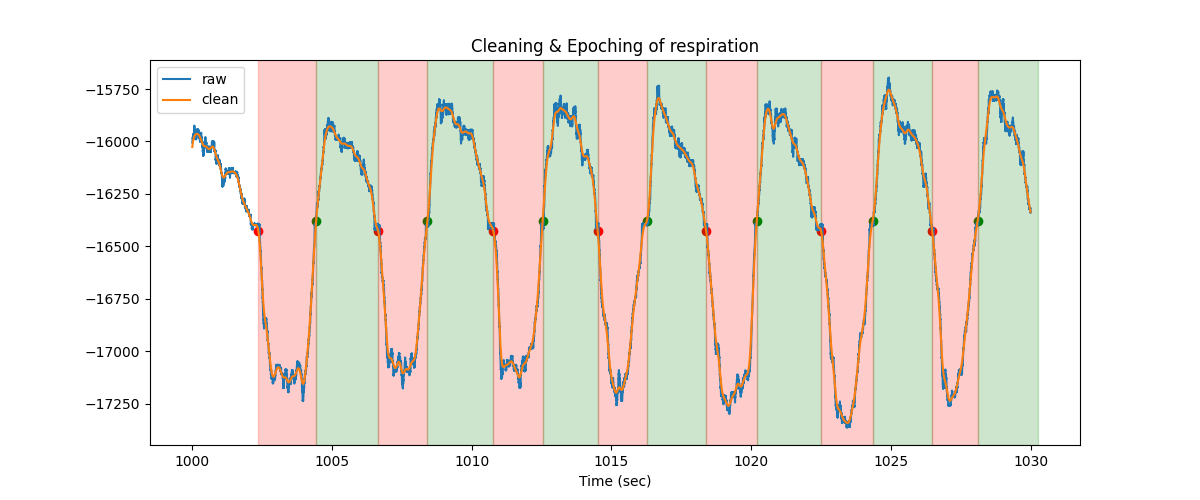

In [14]:
start, stop = 1000, 1030

mask_t = (times > start) & (times < stop)

mask_cycles_t = (resp_cycles['inspi_time'] > start) &  (resp_cycles['expi_time'] < stop)
resp_cycles_window = resp_cycles[mask_cycles_t]
inspi, expi = resp_cycles_window['inspi_time'], resp_cycles_window['expi_time']
inspi_ind, expi_ind = resp_cycles_window['inspi_index'], resp_cycles_window['expi_index']

fig, ax = plt.subplots(figsize = (12,5))
ax.set_title('Cleaning & Epoching of respiration')
ax.plot(times[mask_t], raw_resp[mask_t], label = 'raw')
ax.plot(times[mask_t], resp[mask_t], label = 'clean')
ax.scatter(inspi, resp[inspi_ind], color = 'r')
ax.scatter(expi, resp[expi_ind], color = 'g')

for i, row in resp_cycles_window.iterrows():
    ax.axvspan(xmin = row['inspi_time'], xmax = row['expi_time'], color = 'r', alpha = 0.2)
    ax.axvspan(xmin = row['expi_time'], xmax = row['next_inspi_time'], color = 'g', alpha = 0.2)

ax.set_xlabel('Time (sec)')
ax.legend()

## Working with respiratory features
Doc for resp metrics : https://physio.readthedocs.io/en/latest/examples/example_02_respiration.html#respiration-features-metrics

### See distribution of cycle durations per respiratory block / condition

In [15]:
periods

start_time  duration  stop_time
block_type trial_num                                 
free       1              56.938     300.0    356.938
           2            2869.336     300.0   3169.336
fast       1             634.304     180.0    814.304
           2            1863.984     180.0   2043.984
           3            2610.284     180.0   2790.284
base       1             883.562     180.0   1063.562
           2            1372.779     180.0   1552.779
           3            1611.302     180.0   1791.302
slow       1            1132.622     180.0   1312.622
           2            2122.235     180.0   2302.235
           3            2368.016     180.0   2548.016

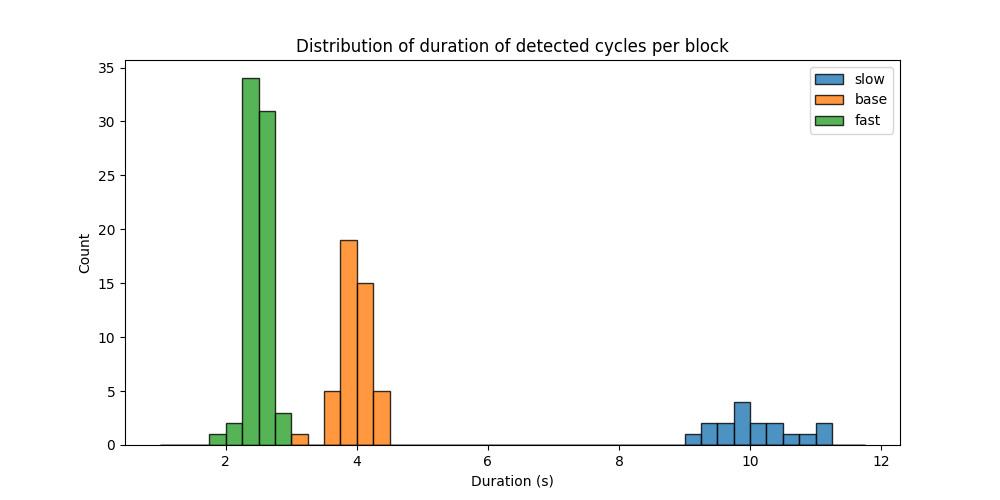

In [16]:
bins = np.arange(1, 12, 0.25)

fig, ax = plt.subplots(figsize = (10,5))
for block_type in ('slow', 'base', 'fast'):
    start_time = periods.loc[(block_type, 1),'start_time']
    stop_time = periods.loc[(block_type, 1),'stop_time']

    mask = (resp_cycles['inspi_time'] > start_time) & (resp_cycles['next_inspi_time'] < stop_time)

    ax.hist(resp_cycles[mask]['cycle_duration'], bins=bins, label=block_type, edgecolor = 'k', alpha = 0.8)
    
ax.set_title('Distribution of duration of detected cycles per block')
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Count')
ax.legend()

### See distribution of inspiratory volumes per respiratory block / condition

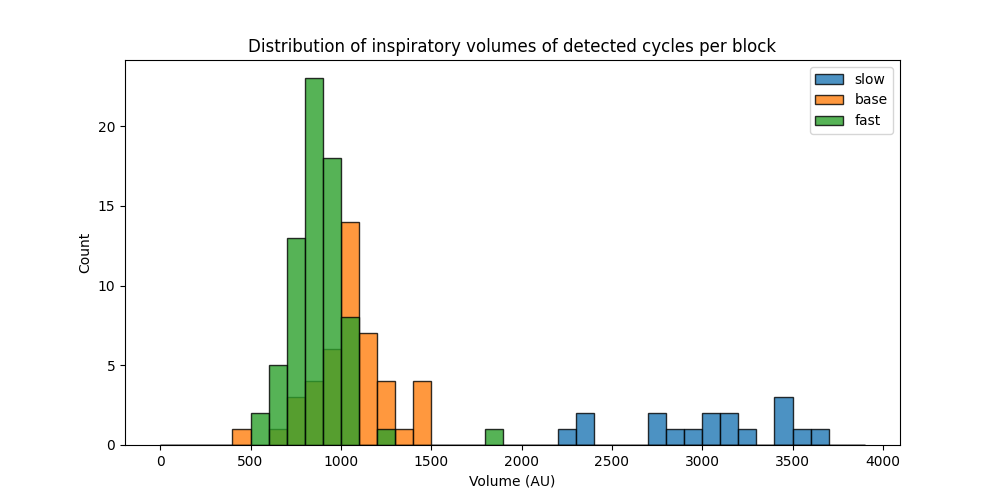

In [17]:
bins = np.arange(0, 4000, 100)

fig, ax = plt.subplots(figsize = (10,5))
for block_type in ('slow', 'base', 'fast'):
    start_time = periods.loc[(block_type, 1),'start_time']
    stop_time = periods.loc[(block_type, 1),'stop_time']

    mask = (resp_cycles['inspi_time'] > start_time) & (resp_cycles['next_inspi_time'] < stop_time)

    ax.hist(resp_cycles[mask]['inspi_volume'], bins=bins, label=block_type, edgecolor = 'k', alpha = 0.8)
    
ax.set_title('Distribution of inspiratory volumes of detected cycles per block')
ax.set_xlabel('Volume (AU)')
ax.set_ylabel('Count')
ax.legend()

### Averaging respiratory features for each respiratory block / condition

In [18]:
resp_metrics = []
for ind, period in periods.iterrows():
    start_time = period['start_time']
    stop_time = period['stop_time']

    mask = (resp_cycles['inspi_time'] > start_time) & (resp_cycles['next_inspi_time'] < stop_time)
    resp_cycles_period = resp_cycles[mask].drop(columns = ['inspi_index','expi_index','next_inspi_index','inspi_time','expi_time','next_inspi_time'])

    metrics = resp_cycles_period.median(axis = 0)
    
    resp_metrics.append(metrics)
resp_metrics = pd.concat(resp_metrics, axis=1).T
resp_metrics = resp_metrics.set_index(periods.index)
resp_metrics

cycle_duration  inspi_duration  expi_duration  \
block_type trial_num                                                  
free       1                  3.0795          1.2450         1.8015   
           2                  3.8000          1.5875         2.2680   
fast       1                  2.4930          1.0810         1.3980   
           2                  2.5040          1.1420         1.3560   
           3                  2.5045          1.1340         1.3650   
base       1                  3.9620          1.7790         2.1990   
           2                  4.0420          1.8415         2.1875   
           3                  4.0240          1.8130         2.1820   
slow       1                  9.9050          4.1780         5.8810   
           2                  9.9280          4.2655         5.7300   
           3                 10.0120          4.7650         5.4030   

                      cycle_freq  cycle_ratio  inspi_volume  expi_volume  \
block_type trial_num                                                       
free       1            0.324728     0.402293   1136.024361  1005.286911   
           2            0.263164     0.414201   1014.010916   569.811737   
fast       1            0.401123     0.434834    872.425317   789.124382   
           2            0.399361     0.455579    576.194357   440.791257   
           3            0.399281     0.455324    623.926838   456.661623   
base       1            0.252398     0.444444   1041.074350   788.271535   
           2            0.247402     0.458695    774.024546   613.868011   
           3            0.248509     0.450828    841.117164   715.189080   
slow       1            0.100959     0.427967   3060.750083  2707.922257   
           2            0.100726     0.429459   2559.580625  2155.340536   
           3            0.099880     0.475004   2035.957365  1328.122983   

                      total_amplitude  inspi_amplitude  expi_amplitude  \
block_type trial_num                                                     
free       1              2403.765610      1420.455115     1003.611018   
           2              1438.825697      1018.691744      444.803571   
fast       1              2078.886111      1212.646704      845.430719   
           2              1255.786335       731.247106      494.997605   
           3              1353.799353       816.547978      542.067267   
base       1              1517.296051       946.844357      559.529533   
           2              1125.360316       640.823910      490.339620   
           3              1228.534375       725.196430      477.563225   
slow       1              2067.761537      1095.474005      870.791748   
           2              1618.671627       927.735913      627.287496   
           3              1065.156084       587.577147      436.904091   

                      inspi_peak_index  expi_peak_index  inspi_peak_time  \
block_type trial_num                                                       
free       1                  204595.0         205785.0         204.5950   
           2                 3032074.0        3034118.5        3032.0740   
fast       1                  722977.0         723958.0         722.9770   
           2                 1952684.0        1953716.0        1952.6840   
           3                 2699984.5        2701017.0        2699.9845   
base       1                  971269.0         973006.0         971.2690   
           2                 1462321.5        1464043.5        1462.3215   
           3                 1699007.0        1701329.0        1699.0070   
slow       1                 1218114.0        1220786.0        1218.1140   
           2                 2201340.0        2206736.0        2201.3400   
           3                 2451767.0        2456530.0        2451.7670   

                      expi_peak_time  total_volume  
block_type trial_num                                
free       1                205.7850   2168.374318 

# ECG analysis
ECG doc : https://physio.readthedocs.io/en/latest/examples/example_03_ecg.html

## Setting parameters using *parameter_preset* = a tree of parameters already prepared by the developers

In [19]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_preset='human_ecg') # using parameter_preset human_ecg*
print('Number of detected heartbeats :', ecg_peaks.shape[0])

Number of detected heartbeats : 4519


In [20]:
# just print a view of the parameters used
physio.get_ecg_parameters('human_ecg')

{'preprocess': {'band': [5.0, 45.0],
  'ftype': 'bessel',
  'order': 5,
  'normalize': True},
 'peak_detection': {'thresh': 'auto', 'exclude_sweep_ms': 4.0},
 'peak_clean': {'min_interval_ms': 400.0}}

## Customising parameters if the default are inappropriate
See : https://physio.readthedocs.io/en/latest/handling_parameters.html#a-human

In [21]:
parameters = physio.get_ecg_parameters('human_ecg')
parameters['peak_detection']['thresh'] = 30 # ex: set a manual detection threshold, at 5
ecg2, ecg_peaks2 = physio.compute_ecg(raw_ecg, srate, parameters = parameters)

## See table of R peak detections

In [22]:
ecg_peaks

,peak_index,peak_time
0,641,0.641
1,1346,1.346
2,2006,2.006
3,2660,2.660
4,3336,3.336
...,...,...
4514,3180101,3180.101
4515,3180762,3180.762
4516,3181447,3181.447
4517,3182154,3182.154


## See preprocessed signal with detections

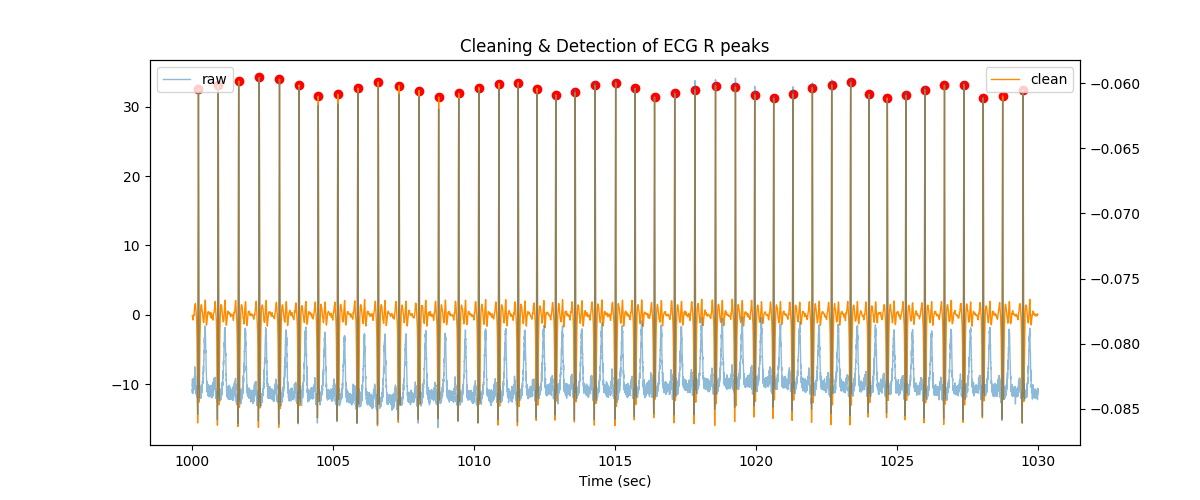

In [23]:
start, stop = 1000, 1030

mask_t = (times > start) & (times < stop)

peaks_mask = (ecg_peaks['peak_time'] > start) & (ecg_peaks['peak_time'] < stop)
r_peaks = ecg_peaks[peaks_mask]

fig, ax = plt.subplots(figsize = (12,5))
ax.set_title("Cleaning & Detection of ECG R peaks")
ax2 = ax.twinx()
ax2.plot(times[mask_t], raw_ecg[mask_t], lw = 1, label = 'raw', alpha = 0.5)

ax.plot(times[mask_t], ecg[mask_t], lw = 1, label = 'clean', color = 'darkorange')
ax.scatter(r_peaks['peak_time'], ecg[r_peaks['peak_index']], color = 'r')

ax.set_xlabel('Time (sec)')
ax.legend()
ax2.legend(loc = 2)

## Computing heart rate features

### Let's first see the distributions of the RR intervals according to the some respiratory blocks / conditions

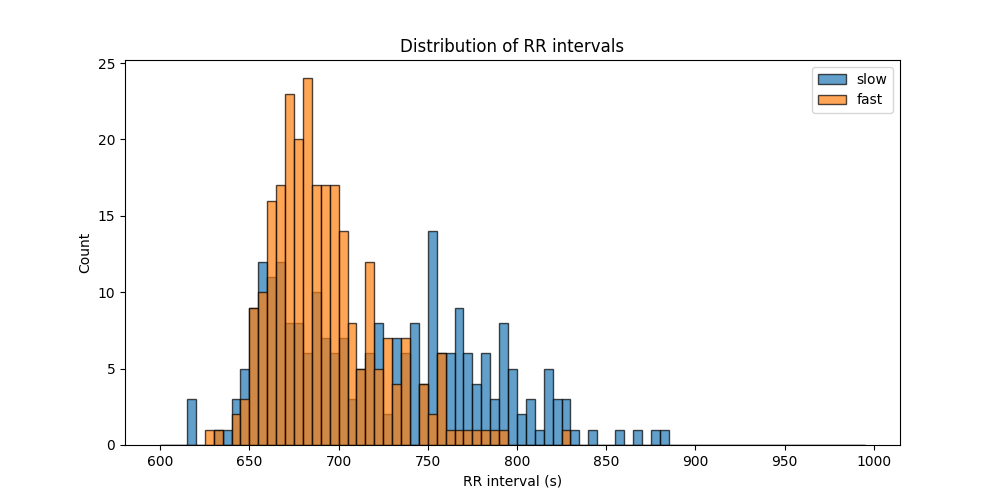

In [24]:
bins = np.arange(600, 1000, 5)

fig, ax = plt.subplots(figsize = (10,5))
for block_type in ('slow','fast'):
    start_time = periods.loc[(block_type, 1),'start_time']
    stop_time = periods.loc[(block_type, 1),'stop_time']

    mask = (ecg_peaks['peak_time'] > start_time) & (ecg_peaks['peak_time'] < stop_time)
    peak_times = ecg_peaks[mask]['peak_time'].values

    rri = np.diff(peak_times) * 1000 # first derivative of R peak timings and * 1000 to get milliseconds from seconds

    ax.hist(rri, bins=bins, label=block_type, alpha=0.7, edgecolor = 'k')
    
ax.set_title('Distribution of RR intervals')
ax.set_xlabel('RR interval (s)')
ax.set_ylabel('Count')
ax.legend()

### Compute time-domain HRV metrics per respiratory block / condition
cf : https://physio.readthedocs.io/en/latest/examples/example_03_ecg.html#heart-rate-variability-metrics-time-domain

In [25]:
hrv_metrics = []
for ind, period in periods.iterrows():
    start_time = period['start_time']
    stop_time = period['stop_time']

    mask = (ecg_peaks['peak_time'] > start_time) & (ecg_peaks['peak_time'] < stop_time)
    peaks_period = ecg_peaks[mask]

    metrics = physio.compute_ecg_metrics(peaks_period, min_interval_ms=500., max_interval_ms=2000.) # use physio.compute_ecg_metrics
    
    hrv_metrics.append(metrics)
hrv_metrics = pd.concat(hrv_metrics, axis=1).T
hrv_metrics = hrv_metrics.set_index(periods.index)
hrv_metrics


HRV_Mean     HRV_SD  HRV_Median    HRV_Mad    HRV_CV  \
block_type trial_num                                                           
free       1          686.164760  39.253915       687.0  37.065055  0.057208   
           2          734.578431  52.168644       729.0  41.512862  0.071018   
fast       1          692.667954  30.936568       687.0  25.204238  0.044663   
           2          707.201581  21.233570       706.0  20.756431  0.030025   
           3          733.418033  25.519629       733.0  28.169442  0.034795   
base       1          698.980545  23.133759       699.0  23.721635  0.033096   
           2          695.302326  23.264107       694.0  22.980334  0.033459   
           3          707.735178  19.496149       705.0  20.756431  0.027547   
slow       1          723.737903  56.167088       721.0  68.941003  0.077607   
           2          746.037500  60.728311       740.5  69.682304  0.081401   
           3          747.512500  61.878778       740.0  76.354014  0.082780   

                       HRV_MCV  HRV_Asymmetry  HRV_RMSSD  
block_type trial_num                                      
free       1          0.053952       0.835240  20.334756  
           2          0.056945      -5.578431  29.881050  
fast       1          0.036687      -5.667954  21.812005  
           2          0.029400      -1.201581  22.690289  
           3          0.038430      -0.418033  29.777778  
base       1          0.033937       0.019455  17.338316  
           2          0.033113      -1.302326  17.817711  
           3          0.029442      -2.735178  16.906019  
slow       1          0.095619      -2.737903  27.439665  
           2          0.094102      -5.537500  31.091914  
           3          0.103181      -7.512500  30.231879

### Compute frequency-domain HRV metrics just for demonstration
https://physio.readthedocs.io/en/latest/examples/example_03_ecg.html#heart-rate-variability-metrics-frequency-domain

lf    9.363311
hf    2.739788
dtype: float64


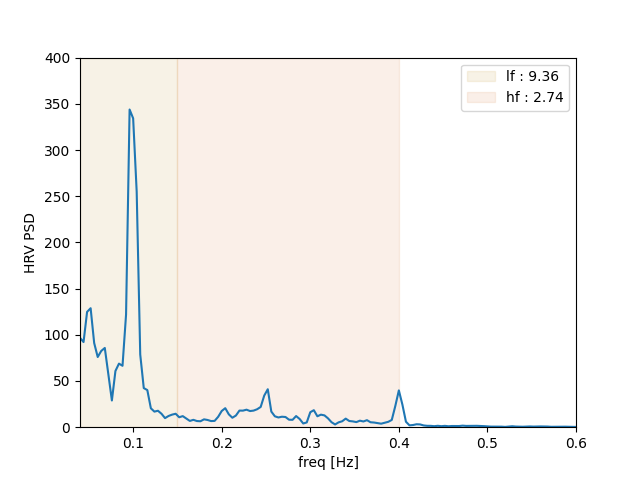

In [26]:
frequency_bands = {'lf': (0.04, .15), 'hf' : (0.15, .4)}
psd_freqs, psd, psd_metrics = physio.compute_hrv_psd(
    ecg_peaks,
    sample_rate=100.,
    limits=None,
    units='bpm',
    frequency_bands=frequency_bands,
    window_s=250.,
    interpolation_kind='cubic',
)

print(psd_metrics)

fig, ax = plt.subplots()
# ax.semilogy(psd_freqs, psd)
ax.plot(psd_freqs, psd)
colors = {'lf': '#B8860B', 'hf' : '#D2691E'}
for name, freq_band in frequency_bands.items():
    ax.axvspan(*freq_band, alpha=0.1, color=colors[name], label=f'{name} : {psd_metrics[name]:.2f}')
ax.set_xlim(0.04, 0.6)
ax.set_ylim(0, 400)
ax.set_xlabel('freq [Hz]')
ax.set_ylabel('HRV PSD')
ax.legend()


# Computing Respiratory Heart Rate Variability (RespHRV) 
See :  https://physio.readthedocs.io/en/latest/examples/example_05_resphrv.html

##  Compute a set of features for each respiratory cycles
See : https://physio.readthedocs.io/en/latest/examples/example_05_resphrv.html#resphrv-features-metrics

In [27]:
points_per_cycle = 50

resphrv_cycles, cyclic_cardiac_rate = physio.compute_resphrv(
    resp_cycles,
     ecg_peaks,
     srate=10.,
     two_segment=True,
     points_per_cycle=points_per_cycle,
)

resphrv_cycles

,peak_index,trough_index,peak_time,trough_time,peak_value,trough_value,rising_amplitude,decay_amplitude,rising_duration,decay_duration,rising_slope,decay_slope
0,20,47,2.063,4.763,91.735537,83.434173,NaN,8.301364,NaN,2.7,NaN,3.074579
1,61,75,6.136,7.536,89.057695,86.114855,5.623522,2.942840,1.373,1.4,4.095792,2.102029
2,89,117,8.939,11.739,91.439804,77.639347,5.324948,13.800457,1.403,2.8,3.795402,4.928735
3,132,146,13.258,14.658,87.947620,82.100996,10.308273,5.846624,1.519,1.4,6.786223,4.176160
4,160,175,16.053,17.553,86.905449,79.062101,4.804453,7.843348,1.395,1.5,3.444052,5.228899
...,...,...,...,...,...,...,...,...,...,...,...,...
827,31661,31676,3166.186,3167.686,84.086133,79.240635,7.201606,4.845497,2.250,1.5,3.200714,3.230332
828,31691,31712,3169.134,3171.234,86.431773,80.583848,7.191138,5.847924,1.448,2.1,4.966255,2.784726
829,31727,31740,3172.700,3174.000,88.360901,86.341211,7.777053,2.019690,1.466,1.3,5.304947,1.553608
830,31754,31781,3175.442,3178.142,90.451139,88.110368,4.109928,2.340771,1.442,2.7,2.850158,0.866952


In [28]:
resphrv_cycles.mean()

peak_index          14951.569712
trough_index        14969.758413
peak_time            1495.207502
trough_time          1497.026373
peak_value             88.550855
trough_value           83.120575
rising_amplitude        5.428679
decay_amplitude         5.430280
rising_duration         2.005029
decay_duration          1.818870
rising_slope            3.115376
decay_slope             2.985339
dtype: float64

## Getting Instantaneous Heart Rate from ECG

In [29]:
instantaneous_heart_rate = physio.compute_instantaneous_rate(ecg_peaks, times, units='bpm', interpolation_kind='linear')

(900.0, 930.0)

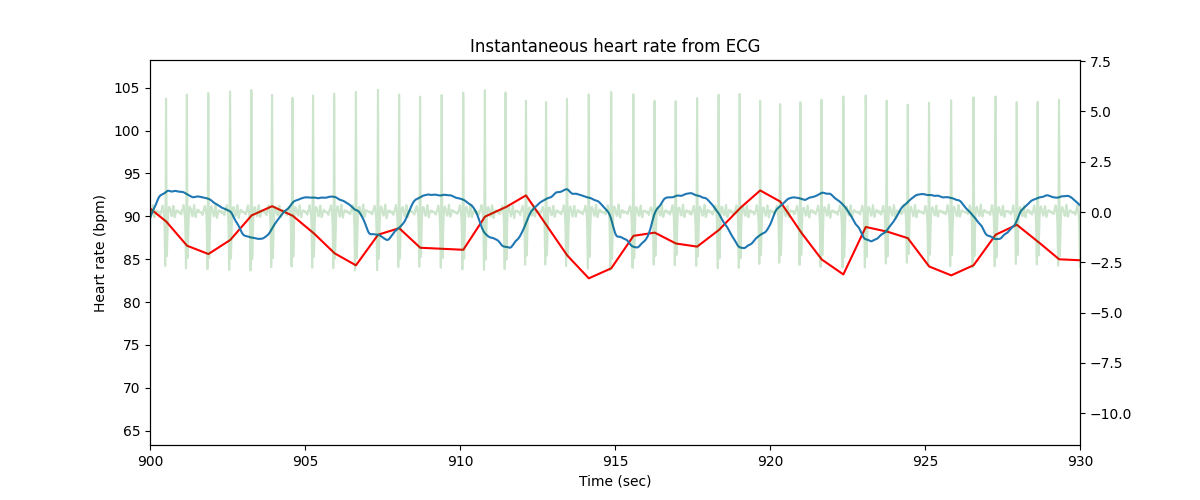

In [30]:
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(times, instantaneous_heart_rate, color = 'r')
ax.set_ylabel('Heart rate (bpm)')
ax.set_title('Instantaneous heart rate from ECG')

ax2 = ax.twinx()
resp_normalized = (resp - resp.mean()) / resp.std()
ecg_normalized = (ecg - ecg.mean()) / ecg.std()
ax2.plot(times, resp_normalized)
ax2.plot(times, ecg_normalized,  alpha=0.2 , color = 'g')

ax.set_xlabel('Time (sec)')

ax.set_xlim(900, 930)
# ax.set_ylim(80, 90)

## Epoching & streching heart rate signal
https://physio.readthedocs.io/en/latest/examples/example_04_cyclic_deformation.html

In [31]:
points_per_cycle = 100
one_cycle = np.arange(points_per_cycle) / points_per_cycle

# two segments respiratory cycle strech
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))
segment_ratios = [inspi_ratio]

cyclic_resp_2seg = physio.deform_traces_to_cycle_template(resp, times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

# two segments cyclic cardiac rate
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))

segment_ratios = [inspi_ratio]

cyclic_cardiac_rate_2seg = physio.deform_traces_to_cycle_template(instantaneous_heart_rate, times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

(0.0, 1.0)

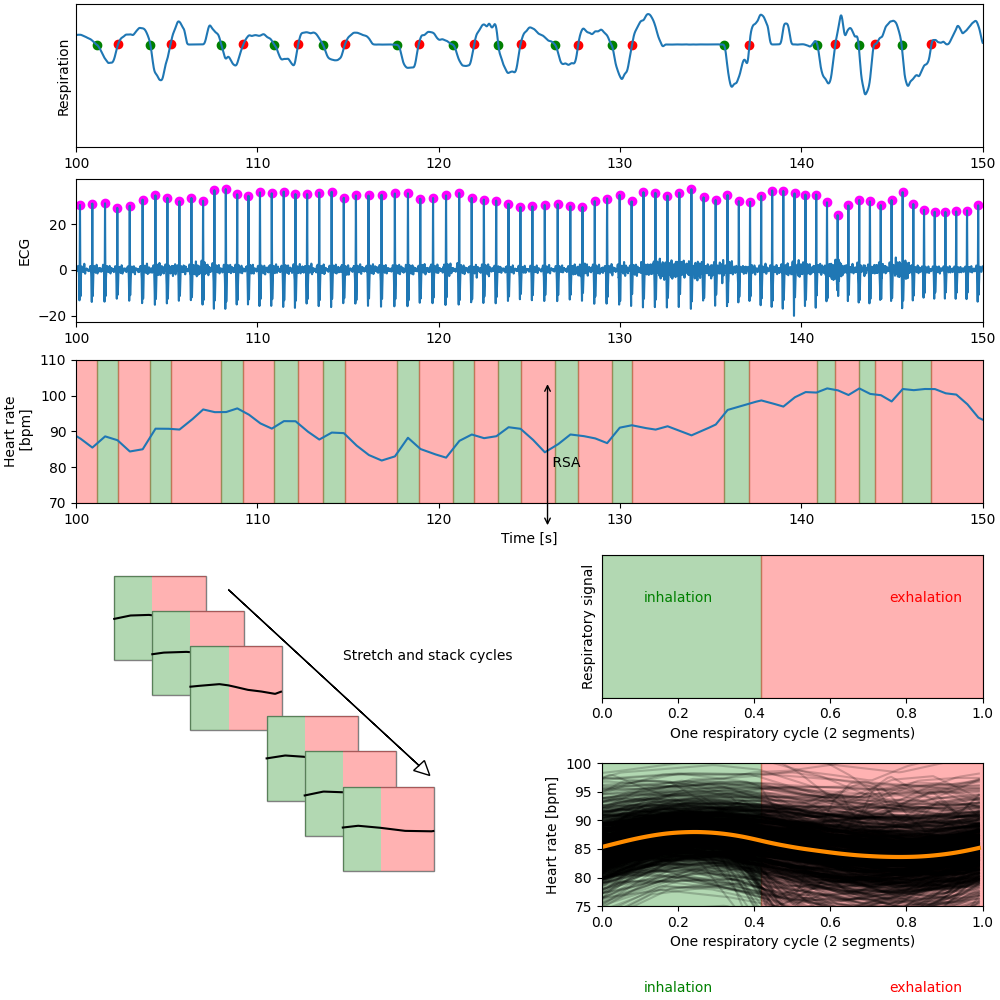

In [32]:
# Many ugly matplotlib code for a quite clear figure…

fig = plt.figure(layout="constrained", figsize=(10, 10))
gs = plt.GridSpec(nrows=5, ncols=4, figure=fig)

ax = ax_A = fig.add_subplot(gs[0, :])

ax.set_ylabel('Respiration')
ax.plot(times, resp)
inspi_index = resp_cycles['inspi_index'].values
expi_index = resp_cycles['expi_index'].values
ax.scatter(times[inspi_index], resp[inspi_index], marker='o', color='green')
ax.scatter(times[expi_index], resp[expi_index], marker='o', color='red')
ax.set_yticks([])
# ax.set_ylim(-1750, -1450)

ax = ax_B = fig.add_subplot(gs[1, :],  sharex=ax)
ax.set_ylabel('ECG')

ax.plot(times, ecg)
ecg_peak_ind = ecg_peaks['peak_index'].values
ax.scatter(times[ecg_peak_ind], ecg[ecg_peak_ind], marker='o', color='magenta')

ax = ax_C = fig.add_subplot(gs[2, :], sharex=ax)
ax.set_ylabel('Heart rate\n [bpm]')
ax.plot(times, instantaneous_heart_rate)
for c, cycle in resp_cycles.iterrows():
    ax.axvspan(cycle['inspi_time'], cycle['expi_time'], color='g', alpha=0.3)
    ax.axvspan(cycle['expi_time'], cycle['next_inspi_time'], color='r', alpha=0.3)
ax.set_ylim(70, 110)
ax.set_xlim(100, 150)
ax.annotate(text='', xy=(126,104), xytext=(126, 63), arrowprops=dict(arrowstyle='<->'))
ax.text(126, 80, ' RSA', ha='left')
ax.set_xlabel('Time [s]')


ax = ax_D = fig.add_subplot(gs[3:, :2])
for k in ('top', 'right', 'left', 'bottom'):
    ax.spines[k].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
w = 120.
rectangles = []
for i in range(7):
    if i in (3, ):
        continue
    z = (i + 1) * 10
    x = 100 + i * 50
    y = 400 - i * 50
    rect = plt.Rectangle((x, y), w, w, ec='gray', fc='w', zorder=z+1)
    ax.add_patch(rect)
    rect = plt.Rectangle((x, y), w*inspi_ratio, w, ec=None, fc='g', alpha=0.3, zorder=z+2)
    ax.add_patch(rect)
    rect = plt.Rectangle((x + w * inspi_ratio, y), w * (1 - inspi_ratio), w,  ec=None, fc='r', alpha=0.3, zorder=z+3)
    ax.add_patch(rect)
    cycle_phase = np.arange(points_per_cycle) / points_per_cycle
    cycle_value = cyclic_cardiac_rate_2seg[i, :]
    ax.plot(cycle_phase * w + x, cycle_value + y + w /2 - np.mean(cycle_value), color='black', zorder=z + 5)
ax.arrow(250, 500, 250, -250, head_width=20, head_length=20, fc='w', ec='k')
ax.text(400, 400, "Stretch and stack cycles")


ax.set_xlim(50, 550)
ax.set_ylim(50, 550)


ax = ax_E = fig.add_subplot(gs[3, 2:])
ax.plot(one_cycle, cyclic_resp_2seg.T, color='k', alpha=0.2)
ax.plot(one_cycle, np.mean(cyclic_resp_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylabel('Respiratory signal')
ax.text(0.2, -1600, 'inhalation', ha='center', color='g')
ax.text(0.85, -1600, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_ylim(-1800, -1500)


ax = ax_F = fig.add_subplot(gs[4, 2:])
ax.plot(one_cycle, cyclic_cardiac_rate_2seg.T, color='k', alpha=0.2)
ax.plot(one_cycle, np.mean(cyclic_cardiac_rate_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylim(75, 100)
ax.set_ylabel('Heart rate [bpm]')
ax.text(0.2, 60, 'inhalation', ha='center', color='g')
ax.text(0.85, 60, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)




## Short example of study of interaction RespHRV <-> respiration metrics
https://physio.readthedocs.io/en/latest/examples/example_05_resphrv.html#explore-covariations-between-resphrv-and-respiratory-features

In [33]:
resphrv_resp = pd.concat([resphrv_cycles, resp_cycles], axis = 1)
resphrv_resp = resphrv_resp.drop(columns = ['trough_time','inspi_index', 'next_inspi_index', 'next_inspi_time',
                                    'inspi_time','expi_index','expi_time'])
resphrv_resp = resphrv_resp.dropna()
resphrv_resp.head()

,peak_index,trough_index,peak_time,peak_value,trough_value,rising_amplitude,decay_amplitude,rising_duration,decay_duration,rising_slope,...,inspi_volume,expi_volume,total_amplitude,inspi_amplitude,expi_amplitude,inspi_peak_index,expi_peak_index,inspi_peak_time,expi_peak_time,total_volume
1,61,75,6.136,89.057695,86.114855,5.623522,2.942840,1.373,1.4,4.095792,...,1414.833227,1187.936916,2957.963555,1919.433711,1038.529844,5879,7383,5.879,7.383,2602.770143
2,89,117,8.939,91.439804,77.639347,5.324948,13.800457,1.403,2.8,3.795402,...,1583.845519,930.237413,3169.787636,2243.563702,926.223934,8781,10097,8.781,10.097,2514.082932
3,132,146,13.258,87.947620,82.100996,10.308273,5.846624,1.519,1.4,6.786223,...,1980.492581,1562.718711,3773.554095,2618.849293,1154.704802,12686,13946,12.686,13.946,3543.211292
4,160,175,16.053,86.905449,79.062101,4.804453,7.843348,1.395,1.5,3.444052,...,1442.390591,990.064264,2518.948206,1585.066101,933.882105,16021,17486,16.021,17.486,2432.454855
5,204,225,20.489,89.108222,82.636197,10.046121,6.472026,2.936,2.1,3.421703,...,1508.677788,1118.046541,3080.701045,1986.014494,1094.686551,20648,21918,20.648,21.918,2626.724329


In [34]:
correlation = resphrv_resp.corr(method = 'spearman')
correlation

,peak_index,trough_index,peak_time,peak_value,trough_value,rising_amplitude,decay_amplitude,rising_duration,decay_duration,rising_slope,...,inspi_volume,expi_volume,total_amplitude,inspi_amplitude,expi_amplitude,inspi_peak_index,expi_peak_index,inspi_peak_time,expi_peak_time,total_volume
peak_index,1.000000,1.000000,1.000000,-0.339971,-0.420556,0.261395,0.226485,0.232458,0.157786,0.102778,...,-0.244356,-0.428159,-0.549460,-0.468699,-0.612794,1.000000,1.000000,1.000000,1.000000,-0.335365
trough_index,1.000000,1.000000,1.000000,-0.339971,-0.420556,0.261395,0.226485,0.232458,0.157786,0.102778,...,-0.244356,-0.428159,-0.549460,-0.468699,-0.612794,1.000000,1.000000,1.000000,1.000000,-0.335365
peak_time,1.000000,1.000000,1.000000,-0.339971,-0.420556,0.261395,0.226485,0.232458,0.157786,0.102778,...,-0.244356,-0.428159,-0.549460,-0.468699,-0.612794,1.000000,1.000000,1.000000,1.000000,-0.335365
peak_value,-0.339971,-0.339971,-0.339971,1.000000,0.679954,-0.126573,0.026097,0.043362,0.121816,-0.333054,...,0.289777,0.313810,0.265857,0.235800,0.280635,-0.339971,-0.339971,-0.339971,-0.339971,0.310943
trough_value,-0.420556,-0.420556,-0.420556,0.679954,1.000000,-0.335055,-0.604743,-0.227099,-0.342757,-0.224995,...,-0.099429,-0.011559,0.221154,0.191024,0.240938,-0.420556,-0.420556,-0.420556,-0.420556,-0.058735
rising_amplitude,0.261395,0.261395,0.261395,-0.126573,-0.335055,1.000000,0.194225,0.698069,0.230411,0.379825,...,0.301650,0.163816,-0.102596,-0.070116,-0.137863,0.261395,0.261395,0.261395,0.261395,0.240188
decay_amplitude,0.226485,0.226485,0.226485,0.026097,-0.604743,0.194225,1.000000,0.249100,0.631103,-0.053912,...,0.381436,0.246821,-0.003797,0.032889,-0.060216,0.226485,0.226485,0.226485,0.226485,0.329654
rising_duration,0.232458,0.232458,0.232458,0.043362,-0.227099,0.698069,0.249100,1.000000,0.320607,-0.293355,...,0.292745,0.177775,-0.208523,-0.192754,-0.218780,0.232458,0.232458,0.232458,0.232458,0.242389
decay_duration,0.157786,0.157786,0.157786,0.121816,-0.342757,0.230411,0.631103,0.320607,1.000000,-0.083400,...,0.421008,0.304809,-0.097340,-0.068310,-0.124907,0.157786,0.157786,0.157786,0.157786,0.379316
rising_slope,0.102778,0.102778,0.102778,-0.333054,-0.224995,0.379825,-0.053912,-0.293355,-0.083400,1.000000,...,0.015050,-0.028772,0.090043,0.108916,0.056253,0.102778,0.102778,0.102778,0.102778,-0.004149


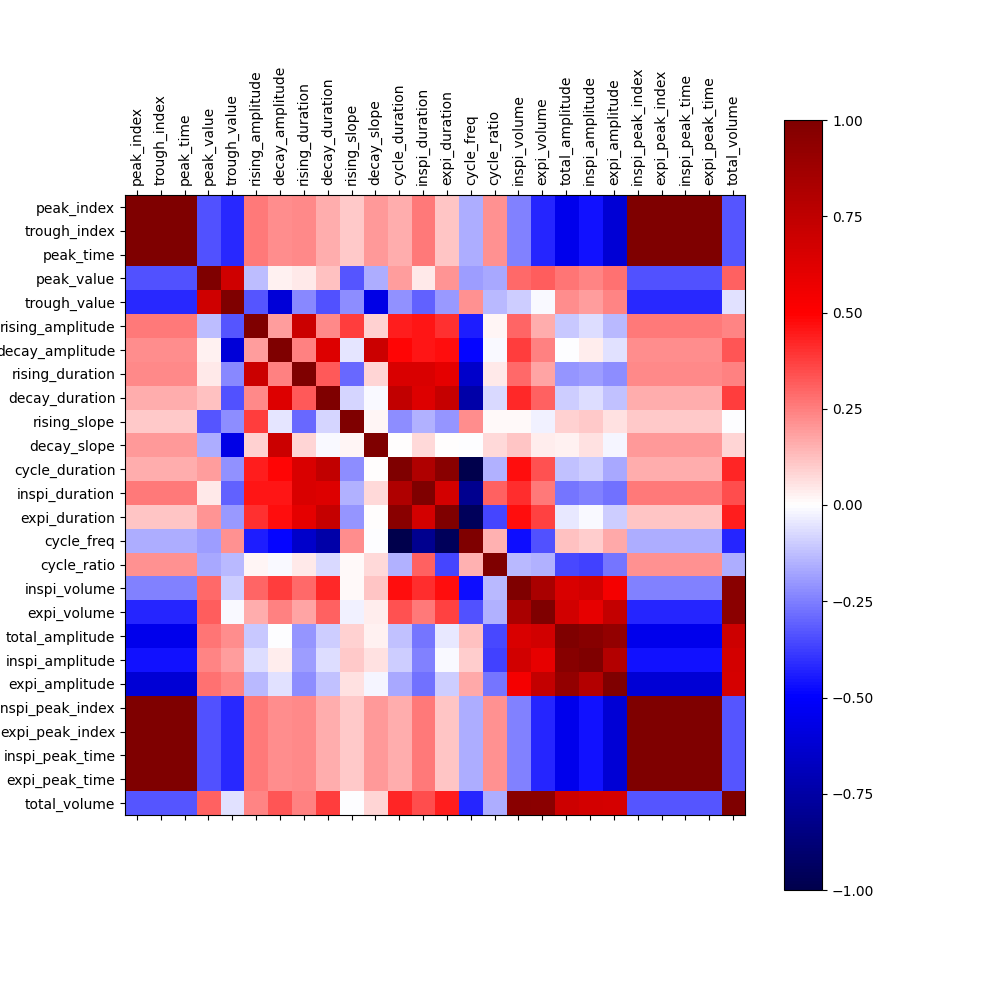

In [35]:
cols = correlation.index.values
fig, ax = plt.subplots(figsize = (10,10))
im = ax.matshow(correlation.values, cmap='seismic')
ax.set_xticks(np.arange(cols.size))
ax.set_xticklabels(cols, rotation=90)
ax.set_yticks(np.arange(cols.size))
ax.set_yticklabels(cols)
im.set_clim(-1, 1)
fig.colorbar(im)